# Example: Center of Mass calculation

Prerequisites: 

 * a python3.6 virtualenv with all requirements installed
  * ``pip install -e .`` in your LiberTEM source dir
  * ``pip install hyperspy hyperspy_gui_ipywidgets notebook`` for additional dependencies
 * a HDF5 dataset

In [1]:
%matplotlib nbagg

We disable threading in OpenBLAS because it would interfere with the dask multiprocessing and because OpenBLAS likes to call ``sched_yield`` for no discernable reason

In [2]:
%env OMP_NUM_THREADS=1
%env OPENBLAS_NUM_THREADS=1

env: OMP_NUM_THREADS=1
env: OPENBLAS_NUM_THREADS=1


Import our dependencies. There may be some warnings about ``hyperspy_gui_traitui`` and so on which can be safely ignored (you do need ``hyperspy_gui_ipywidgets`` though):

In [3]:
from libertem.io.dataset.hdf5 import H5DataSet
from libertem.executor.dask import DaskJobExecutor
from libertem.executor.inline import InlineJobExecutor
from libertem.job.masks import ApplyMasksJob
from libertem.masks import gradient_x, gradient_y
from scipy.ndimage import measurements
from dask import distributed as dd
import numpy as np
import hyperspy.api as hs
import matplotlib.pyplot as plt

/home/clausen/.virtualenvs/libertem/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [4]:
tileshape = (1, 8, 128, 128)
dataset_path = "/home/clausen/Data/EMPAD/scan_11_x256_y256.emd"

ds = H5DataSet(
    path=dataset_path,
    ds_path="experimental/science_data/data",
    
    tileshape=tileshape,
    target_size=512*1024*1024,
)
ds

<H5DataSet of float32 shape=(256, 256, 128, 128)>

Now, we prepare for the actual computation. Center of Mass for a 2D image means multiplying each pixel's intensity with it's position and dividing by the sum of all pixel intensities. We do this separately for ``x`` and ``y`` axis by creating a gradient ``0..127`` for each axis, and a "all ones" mask for the sum of all pixels:

In [5]:
masks=[
    # summation of all pixels:
    lambda: np.ones(shape=ds.shape[2:]),
    
    # gradient from left to right
    lambda: gradient_x(*ds.shape[2:]),
    
    # gradient from top to bottom
    lambda: gradient_y(*ds.shape[2:]),
]
%time gradient_x(*ds.shape[2:])

CPU times: user 474 µs, sys: 143 µs, total: 617 µs
Wall time: 567 µs


array([[  0.,   1.,   2., ..., 125., 126., 127.],
       [  0.,   1.,   2., ..., 125., 126., 127.],
       [  0.,   1.,   2., ..., 125., 126., 127.],
       ...,
       [  0.,   1.,   2., ..., 125., 126., 127.],
       [  0.,   1.,   2., ..., 125., 126., 127.],
       [  0.,   1.,   2., ..., 125., 126., 127.]], dtype=float32)

Now we set up the parameters for the job. If you want to run this notebook, you may need to adjust the ``dataset_path`` variable and ``ds_path`` parameter here. This example uses a local HDF5 file as input dataset, but you can use the HDFS DataSet implementation if you want to use your cluster.

In [6]:
job = ApplyMasksJob(dataset=ds, mask_factories=masks)

if True:
    cluster = dd.LocalCluster(threads_per_worker=1)
    client = dd.Client(cluster)
    executor = DaskJobExecutor(client=client, is_local=True)
else:
    executor = DaskJobExecutor(scheduler_uri="tcp://localhost:8786", is_local=True)

# executor = DaskJobExecutor.make_local()
# executor = InlineJobExecutor()

For visualization, we create a HyperSpy signal. For each of our masks, it holds the result values for all scan positions. You can use the slider to switch between masks:

<IPython.core.display.Javascript object>


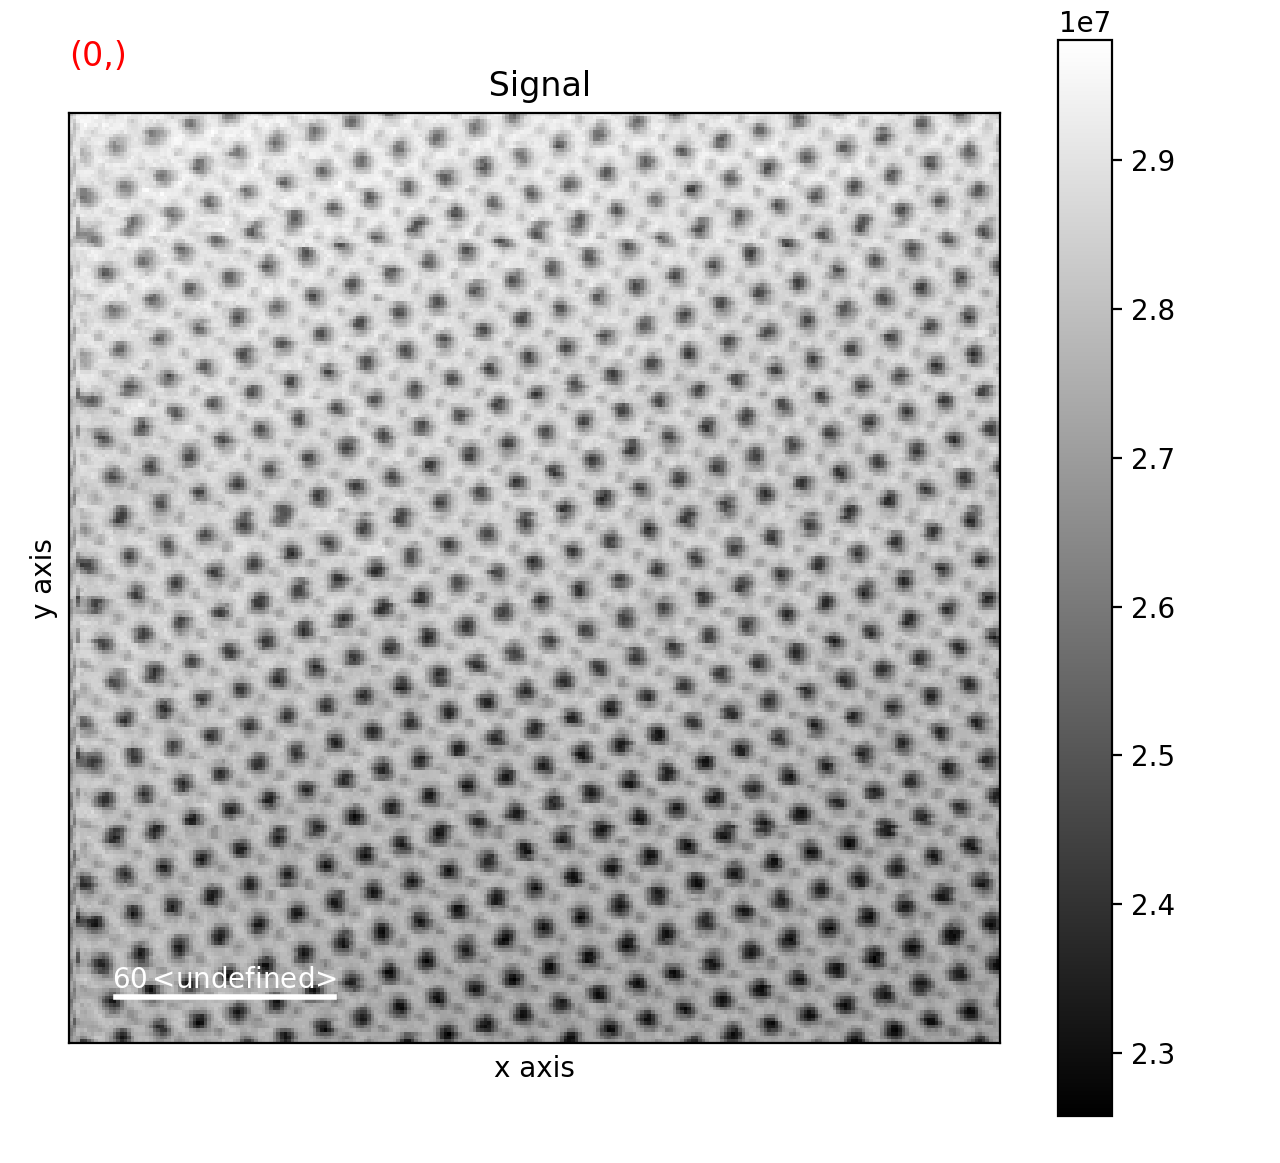

In [7]:
full_result = hs.signals.Signal2D(np.zeros(shape=(len(job.masks), ds.shape[0], ds.shape[1])))
full_result.axes_manager[0].name = "masks"
full_result.axes_manager[1].name = "x"
full_result.axes_manager[2].name = "y"
full_result.plot(navigator="slider")

Now, we kick off the computation:

In [8]:
full_result.data = np.zeros(shape=(len(job.masks), ds.shape[0], ds.shape[1]))
# job.masks.computed_masks  # trigger eager mask creation
def run():
    for result in executor.run_job(job):
        for tile in result:
            tile.copy_to_result(full_result.data)
    return tile  # just the last tile, for inspection
%time tile = run()
full_result.events.data_changed.trigger(full_result)

CPU times: user 3.9 s, sys: 323 ms, total: 4.23 s
Wall time: 1min 14s


Let's create another signal that contains the ``(x, y)`` pairs as signal for each scan position:

In [9]:
x_centers = np.divide(full_result.inav[1].data, full_result.inav[0].data)
y_centers = np.divide(full_result.inav[2].data, full_result.inav[0].data)
centers = hs.signals.Signal1D(np.dstack((x_centers, y_centers)))
centers

<Signal1D, title: , dimensions: (256, 256|2)>

Ok, now that we have our results, let's see how we compare to the ``scipy`` implementation. Let's use HyperSpy to load the dataset lazily (``optimize=False`` because of the lazy signal):

In [10]:
raw_data = hs.load(dataset_path, lazy=True).as_signal2D(image_axes=(0, 1), optimize=False)

Let's have a look at one frame, plot it and see how the result compares to ours:

<IPython.core.display.Javascript object>


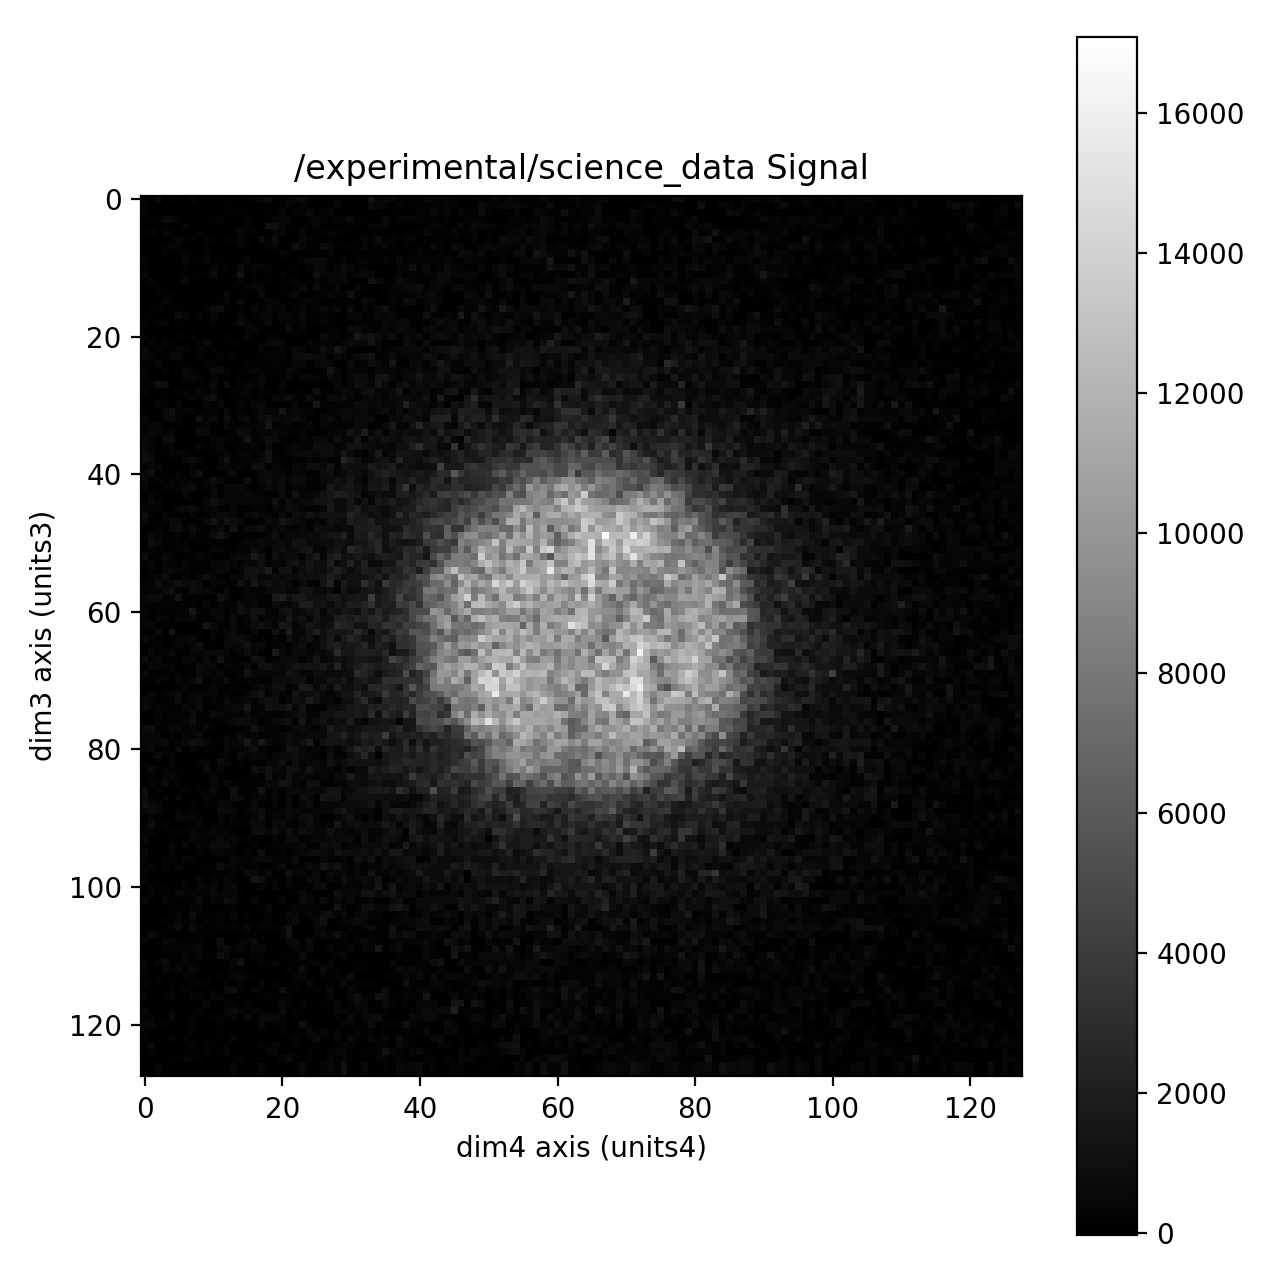

scipy center: x=64.278758, y=63.191338
our center:   x=64.278761, y=63.191348
difference from scipy: x=-0.000003, y=-0.000010


In [11]:
frame_coords = (0, 0)
frame = raw_data.inav[frame_coords]
frame.plot(navigator=None)
frame_data = frame.data.compute()
center_y, center_x = measurements.center_of_mass(frame_data)


# marker = hs.plot.markers.point(x=center_x, y=center_y, color='red')
# frame.add_marker(marker) # -> crashes for some reason


print("scipy center: x=%.6f, y=%.6f" % (center_x, center_y))
print("our center:   x=%.6f, y=%.6f" % (centers.inav[frame_coords].isig[0].data[0],
                                      centers.inav[frame_coords].isig[1].data[0]))
print("difference from scipy: x=%.6f, y=%.6f" % (
    (center_x - centers.inav[frame_coords].isig[0].data[0]),
    (center_y - centers.inav[frame_coords].isig[1].data[0])
))